# Force field parameterization

The fundamental approach of molecular mechanics (MM) is to describe the potential energy of a system approximately as an analytical function of the atomic coordinates. The explicit form of the total energy function, referred to as force field, contains contributions for bond stretching, angle bending, torsion, van der Waals interactions and electrostatic interactions. Organic and bioorganic systems can then be well described by, *e.g.* the simple functional form of Amber force fields:

$$
E_\mathrm{pair} = \sum_\mathrm{bonds} k_r (r-r_{eq})^2 + \sum_\mathrm{angles} k_\theta (\theta-\theta_{eq})^2 + \sum_\mathrm{dihedrals} k_\phi [ 1 + \mathrm{cos}(n\phi - \gamma) ] + \sum_{i<j} \bigl[ \frac{A_{ij}}{R_{ij}^{12}} - \frac{B_{ij}}{R_{ij}^6} + \frac{q_i q_j}{\varepsilon R_{ij}} \bigr]
$$

with the equilibrium structural parameters $r_{eq}$ and $\theta_{eq}$ that can be either taken from an optimized structure or from the data according to the atom types. The assignment of the correct atom types is based on the element type, hybridization, aromaticity, and chemical environment. In the same way, the force constants $k_r$, $k_\theta$ and $k_\phi$, the multiplicity $n$, the dihedral phase angle $\gamma$ and the Lennard-Jones parameters $A$ and $B$ are taken from the data. In case of the general Amber force field (GAFF) the partial charges $q$ are assigned using the restrained electrostatic potential (RESP) charge model.

The `ForceFieldGenerator` class in `VeloxChem` provides a number of functions to interact with `OpenMM` and manipulate topology files. As an example, we consider the optimization of the force field for two dihedral angles of a thiophene-based optical ligands named HS-276.

## Parameterization of dihedral angles

We here consider two dihedral angles of HS-276, $\phi_1$ and $\phi_2$, as shown here:

```{figure} ../../img/md/hs276.png
---
width: 600px
name: fig_hs
---
```

The dihedral potential curves will be plotted using force field parameters from the general amber forcefield (GAFF) database, as compared to QM results. The force field will then be changed to better fit this potential.

### Set up

We first load the required modules and the equilibrium geometry, and initialize a (empty) force field object:

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

# load B3LYP optimized geometry in the xyz format
xyz_filename = "../../xyz/md/hs276.xyz"
molecule = vlx.Molecule.read_xyz(xyz_filename)
ff_gen = vlx.ForceFieldGenerator()
ff_gen.scan_dih_angles = []
ff_gen.scan_energies = []
ff_gen.scan_geometries = []
ff_gen.target_dihedrals = []

The QM scans of the two dihedrals is read and put in the `ff_gen` object:

```python
ff_gen.read_qm_scan_xyz_files(['../../xyz/md/1_14_15_16.xyz', '../../xyz/md/27_22_21_16.xyz'])
```

Furthermore, RESP chargeds are provided:

In [ ]:
resp_chg = [
    0.014967, 0.224409, 0.089489, -0.551618, 0.153050, 0.106847, -0.315042,
    0.165854, 0.206441, -0.425163, 0.225816, -0.039099, 0.179377, 0.002119,
    0.014483, -0.043666, -0.230202, 0.165960, -0.071404, 0.188598, -0.044661,
    0.088786, -0.173586, 0.175730, -0.089376, 0.164515, -0.118573, -0.150541,
    0.736497, -0.570770, -0.273724, -0.144051, 0.112846, 0.112846, 0.112846
]

Finally, we provide atom types and (initial) force field files and topology:

In [ ]:
ff_gen.molecule_name = 'hs276'
ff_gen.molecule = molecule
ff_gen.atom_types = ['ca', 'ca', 'h4', 'nb', 'ca', 'h4', 'ca', 'ha', 'ca', 'cd', 'ha',
                     'cd', 'h4', 'na', 'cc', 'ss', 'cd', 'ha', 'cd', 'ha', 'cc', 'cc', 'cd',
                     'ha', 'cd', 'ha', 'ss', 'cc', 'c', 'o', 'os', 'c3', 'h1', 'h1', 'h1']
ff_gen.force_field_data = '../../data/md/gaff-2.11.dat'
ff_gen.force_field_data_extension = '../../data/md/gaff-2.11_extension.dat'

original_itp_file = '../../data/md/hs276_00.itp'
original_top_file = '../../data/md/hs276_00.top'
ff_gen.write_original_itp(original_itp_file, list(ff_gen.atom_types), resp_chg)
ff_gen.write_top(original_top_file, original_itp_file)

### Original GAFF force field

The performance of the original GAFF force field is evaluated by calculating the energy at each dihedral angle from the scan:

```python
res_phi1 = ff_gen.validate_force_field(original_top_file, 0)
res_phi2 = ff_gen.validate_force_field(original_top_file, 1)
```

*Note:* These calculations are not executed in the compilation of the book, and the results are instead loaded below.

In [ ]:
res_phi1 = {'dihedral_indices': [1, 14, 15, 16],
 'dihedral_angles': [0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,  90.0,
                      100.0,  110.0,  120.0,  130.0,  140.0,  150.0,  160.0,  170.0,  180.0],
 'mm_scan_kJpermol': np.array([ 0.38636858,  0.48247293,  1.27570957,  3.36342458,  6.98809449,
        12.13142224, 18.5303525 , 25.62885098, 32.54192822, 37.58017715,
        31.99637207, 25.07828961, 17.94691688, 11.36067857,  5.91695371,
         2.06323565,  0.07655332,  0.        ,  1.51503683]),
 'qm_scan_kJpermol': np.array([7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375,
        1.14209234, 1.24448683, 1.88248324, 2.57298965, 2.70951563,
        2.2185472 , 1.34950681, 0.50672143, 0.        , 0.13652598,
        1.11846285, 2.99044409, 5.39540176, 6.79216757])}
res_phi2 = {'dihedral_indices': [27, 22, 21, 16],
 'dihedral_angles': [0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,
  90.0,  100.0,  110.0,  120.0,  130.0,  140.0,  150.0,  160.0,  170.0,  180.0],
 'mm_scan_kJpermol': np.array([  6.73698578,   8.89934543,  15.06049153,  24.88538725,
         37.83422214,  53.18780112,  70.07821906,  87.530094  ,
        104.49431502, 115.61424453,  99.4539796 ,  81.95008328,
         64.11898505,  46.92700085,  31.30870369,  18.13606105,
          8.16882884,   1.99828301,   0.        ]),
 'qm_scan_kJpermol': np.array([ 3.83585497,  3.39214553,  3.07446008,  3.05870708,  3.79647248,
         5.41640576,  7.76097693, 10.36547258, 12.46062129, 13.21413969,
        12.26370882,  9.96902213,  7.13610802,  4.45022189,  2.31569068,
         0.94255437,  0.29405596,  0.08664149,  0.        ])}
res_phi1_fit = {'dihedral_indices': [1, 14, 15, 16],
 'dihedral_angles': [0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,  90.0,
                       100.0,  110.0,  120.0,  130.0,  140.0,  150.0,  160.0,  170.0,  180.0],
 'mm_scan_kJpermol': np.array([8.85550424, 6.54628496, 3.92072292, 2.18977189, 1.42619785,
        1.39217696, 1.69310874, 1.93478451, 1.92300116, 1.69520266,
        1.40178731, 1.13081008, 0.84304392, 0.45899866, 0.0506388 ,
        0.        , 0.9624034 , 3.60078571, 9.49198035]),
 'qm_scan_kJpermol': np.array([7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375,
        1.14209234, 1.24448683, 1.88248324, 2.57298965, 2.70951563,
        2.2185472 , 1.34950681, 0.50672143, 0.        , 0.13652598,
        1.11846285, 2.99044409, 5.39540176, 6.79216757])}
res_phi2_fit = {'dihedral_indices': [27, 22, 21, 16],
 'dihedral_angles': [0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,
                       90.0,  100.0,  110.0,  120.0,  130.0,  140.0,  150.0,  160.0,
                       170.0,  180.0],
 'mm_scan_kJpermol': np.array([ 3.77011661,  3.4340386 ,  2.92616752,  2.82307531,  3.59515264,
         5.37149162,  7.85506128, 10.40900493, 12.28767184, 12.91265169,
        12.0771715 ,  9.9999376 ,  7.22496312,  4.41920009,  2.14773038,
         0.71490743,  0.09502842,  0.        ,  0.07651008]),
 'qm_scan_kJpermol': np.array([ 3.83585497,  3.39214553,  3.07446008,  3.05870708,  3.79647248,
         5.41640576,  7.76097693, 10.36547258, 12.46062129, 13.21413969,
        12.26370882,  9.96902213,  7.13610802,  4.45022189,  2.31569068,
         0.94255437,  0.29405596,  0.08664149,  0.        ])}
res_phi1_fit_imp1 = {'dihedral_indices': [1, 14, 15, 16],
 'dihedral_angles': [0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,
                     90.0,  100.0,  110.0,  120.0,  130.0,  140.0,  150.0,  160.0,
                       170.0,  180.0],
 'mm_scan_kJpermol': np.array([10.50209112,  8.02223957,  4.94590657,  2.64652847,  1.39729309,
         1.11813384,  1.46934483,  1.98405593,  2.2847002 ,  2.21777892,
         1.82680422,  1.2450606 ,  0.62448599,  0.12913038,  0.        ,
         0.61013567,  2.4092184 ,  5.72247507, 11.88358653]),
 'qm_scan_kJpermol': np.array([7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375,
        1.14209234, 1.24448683, 1.88248324, 2.57298965, 2.70951563,
        2.2185472 , 1.34950681, 0.50672143, 0.        , 0.13652598,
        1.11846285, 2.99044409, 5.39540176, 6.79216757])}
res_phi2_fit_imp1 = {'dihedral_indices': [27, 22, 21, 16],
 'dihedral_angles': [0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,  90.0,
                       100.0,  110.0,  120.0,  130.0,  140.0,  150.0,  160.0,  170.0,  180.0],
 'mm_scan_kJpermol': np.array([ 3.77380665,  3.45659839,  2.97075626,  2.89168948,  3.68036836,
         5.45413796,  7.90762789, 10.40597509, 12.22095797, 12.80156411,
        11.96438867,  9.93400376,  7.23618755,  4.5020705 ,  2.26598738,
         0.81664548,  0.14546155,  0.        ,  0.06206884]),
 'qm_scan_kJpermol': np.array([ 3.83585497,  3.39214553,  3.07446008,  3.05870708,  3.79647248,
         5.41640576,  7.76097693, 10.36547258, 12.46062129, 13.21413969,
        12.26370882,  9.96902213,  7.13610802,  4.45022189,  2.31569068,
         0.94255437,  0.29405596,  0.08664149,  0.        ])}
res_phi1_fit_imp2 = {'dihedral_indices': [1, 14, 15, 16],
 'dihedral_angles': [20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,  90.0,  100.0,
                       110.0,  120.0,  130.0,  140.0,  150.0,  160.0,  170.0],
 'mm_scan_kJpermol': np.array([5.4234754 , 2.89034555, 1.44738438, 1.07147175, 1.42615159,
        2.00013673, 2.36625897, 2.32952195, 1.92383912, 1.30083734,
        0.63897763, 0.1232948 , 0.        , 0.63355979, 2.46041641,
        5.81462796]),
 'qm_scan_kJpermol': np.array([5.23524628, 3.25299405, 1.80634375, 1.14209234, 1.24448683,
        1.88248324, 2.57298965, 2.70951563, 2.2185472 , 1.34950681,
        0.50672143, 0.        , 0.13652598, 1.11846285, 2.99044409,
        5.39540176])}
res_phi2_fit_imp2 = {'dihedral_indices': [27, 22, 21, 16],
 'dihedral_angles': [0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,
                       90.0,  100.0,  110.0,  120.0,  130.0,  140.0,  150.0,  160.0,
                       170.0,  180.0],
 'mm_scan_kJpermol': np.array([ 3.76614678,  3.44072374,  2.93298698,  2.82649038,  3.59577269,
         5.37198654,  7.8574572 , 10.41314745, 12.29166455, 12.91538952,
        12.07832096, 10.00124395,  7.22794208,  4.42314879,  2.15221843,
         0.71672128,  0.09418956,  0.        ,  0.08373556]),
 'qm_scan_kJpermol': np.array([ 3.83585497,  3.39214553,  3.07446008,  3.05870708,  3.79647248,
         5.41640576,  7.76097693, 10.36547258, 12.46062129, 13.21413969,
        12.26370882,  9.96902213,  7.13610802,  4.45022189,  2.31569068,
         0.94255437,  0.29405596,  0.08664149,  0.        ])}

The resulting potentials can be illustrated using functionalities available in VeloxChem:

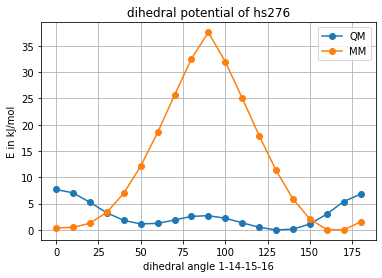

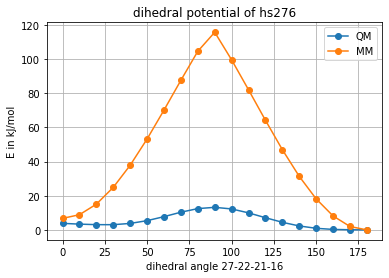

In [32]:
ff_gen.visualize(res_phi1)
ff_gen.visualize(res_phi2)

Alternatively, we can construct custom plotting scripts by first checking the contents of the results dictionaries:

In [24]:
print(res_phi1)

{'dihedral_indices': [1, 14, 15, 16], 'dihedral_angles': [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0], 'mm_scan_kJpermol': array([ 0.38636858,  0.48247293,  1.27570957,  3.36342458,  6.98809449,
       12.13142224, 18.5303525 , 25.62885098, 32.54192822, 37.58017715,
       31.99637207, 25.07828961, 17.94691688, 11.36067857,  5.91695371,
        2.06323565,  0.07655332,  0.        ,  1.51503683]), 'qm_scan_kJpermol': array([7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375,
       1.14209234, 1.24448683, 1.88248324, 2.57298965, 2.70951563,
       2.2185472 , 1.34950681, 0.50672143, 0.        , 0.13652598,
       1.11846285, 2.99044409, 5.39540176, 6.79216757])}


And we then define our own plotting routines:

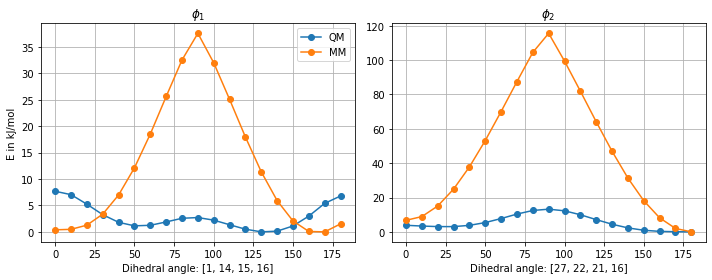

In [33]:
def custom_plot(res1, title1, res2, title2):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title(title1)
    plt.plot(res1["dihedral_angles"], res1["qm_scan_kJpermol"], "o-")
    plt.plot(res1["dihedral_angles"], res1["mm_scan_kJpermol"], "o-")
    plt.legend(("QM", "MM"))
    plt.ylabel("E in kJ/mol")
    plt.xlabel("Dihedral angle: {}".format((res1["dihedral_indices"])))
    plt.grid()
    plt.subplot(122)
    plt.title(title2)
    plt.plot(res2["dihedral_angles"], res2["qm_scan_kJpermol"], "o-")
    plt.plot(res2["dihedral_angles"], res2["mm_scan_kJpermol"], "o-")
    plt.xlabel("Dihedral angle: {}".format((res2["dihedral_indices"])))
    plt.grid()
    plt.tight_layout()
    return False


custom_plot(res_phi1, r"$\phi_1$", res_phi2, r"$\phi_2$")
plt.show()

As is clear, the dihedral angle of the original force field is very poor, and we will now improve this by fitting to the QM potential.

### Fitting to QM potential

Correct original GAFF force field by fitting to QM potential;

```python
target_top_file = original_top_file

for i in range(len(ff_gen.target_dihedrals)):
    target_top_file = ff_gen.dihedral_correction(target_top_file, i)

res_phi1_fit = ff_gen.validate_force_field(target_top_file, 0)
res_phi2_fit = ff_gen.validate_force_field(target_top_file, 1)
```

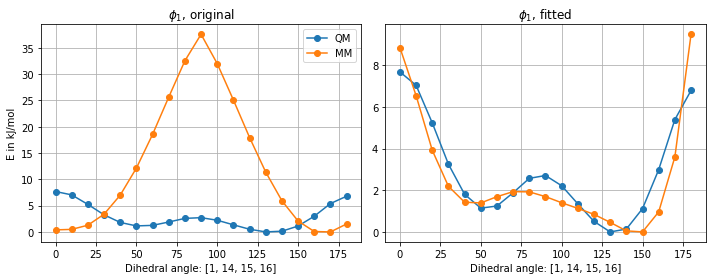

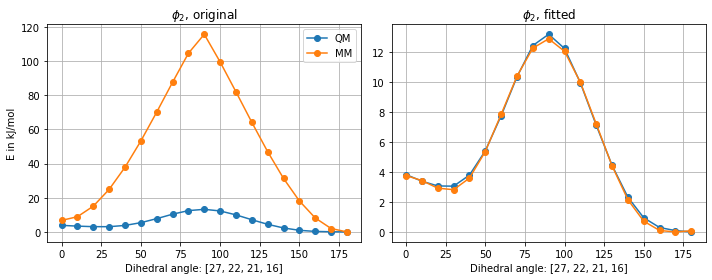

In [34]:
custom_plot(res_phi1, r"$\phi_1$, original", res_phi1_fit, r"$\phi_1$, fitted")
custom_plot(res_phi2, r"$\phi_2$, original", res_phi2_fit, r"$\phi_2$, fitted")
plt.show()

This leads to substantial improvement, but there are still some discrepancies, in particular for the $\phi_1$ dihedral. We will now investigate two different improvements on this.

### Weighted fitting

```python
target_top_file = ff_gen.dihedral_correction(target_top_file, 0, kT=4.0)
target_top_file = ff_gen.dihedral_correction(target_top_file, 1, kT=12.0)

res_phi1_fit_imp1 = ff_gen.validate_force_field(target_top_file, 0)
res_phi2_fit_imp1 = ff_gen.validate_force_field(target_top_file, 1)
```

- Insert more theory, commeting how we fit with favour on low-energy regions which are typically thermally available
- Use same kT for both angles

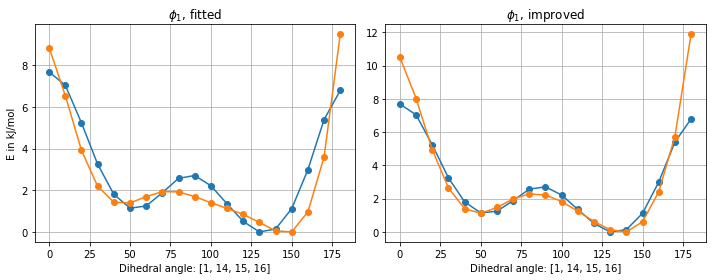

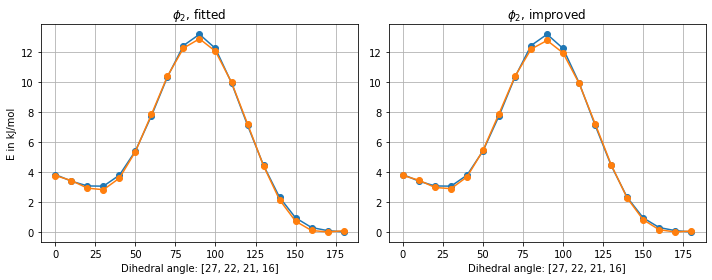

In [27]:
custom_plot(res_phi1_fit, r"$\phi_1$, fitted", res_phi1_fit_imp1, r"$\phi_1$, improved")
custom_plot(res_phi2_fit, r"$\phi_2$, fitted", res_phi2_fit_imp1, r"$\phi_2$, improved")
plt.show()

### Excluding tricky angles

- More theory

```python
ff_gen.update_dihedral_range((20, 170), 0)
print(ff_gen.scan_dih_angles[0])
```

In [ ]:
print([20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0])

```python
for i in range(len(ff_gen.target_dihedrals)):
    target_top_file = ff_gen.dihedral_correction(target_top_file, i)

res_phi1_fit_imp2 = ff_gen.validate_force_field(target_top_file, 0)
res_phi2_fit_imp2 = ff_gen.validate_force_field(target_top_file, 1)
```

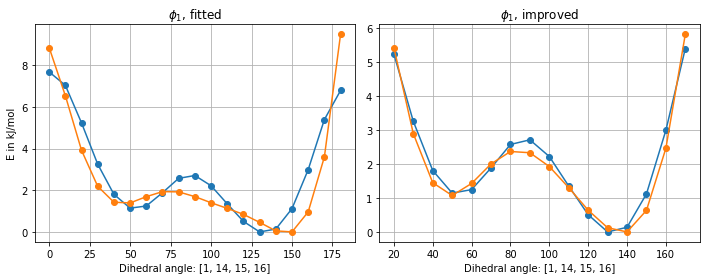

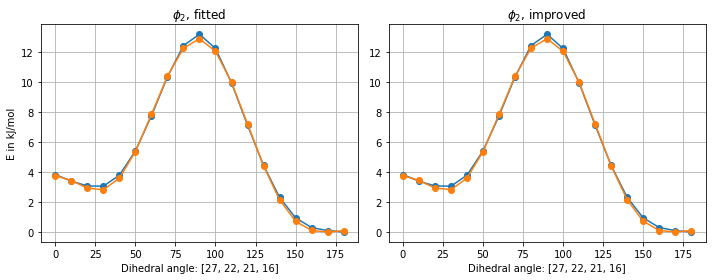

In [29]:
custom_plot(res_phi1_fit, r"$\phi_1$, fitted", res_phi1_fit_imp2, r"$\phi_1$, improved")
custom_plot(res_phi2_fit, r"$\phi_2$, fitted", res_phi2_fit_imp2, r"$\phi_2$, improved")
plt.show()

In [30]:
# Dummy run to make sure fitting works properly
# (above scripts are static, to save computational resources)
ff_gen.read_qm_scan_xyz_files(["../../xyz/md/1_14_15_16_short.xyz"])

target_top_file = original_top_file = "../../data/md/hs276_00.top"
target_top_file = ff_gen.dihedral_correction(target_top_file, 0, kT=4.0)
result_dummy = ff_gen.validate_force_field(target_top_file, 0)

ff_gen.visualize(result_dummy)

"ff_gen.read_qm_scan_xyz_files(['../xyz/md/1_14_15_16_short.xyz'])\n\n\ntarget_top_file = original_top_file = '../data/md/hs276_00.top'\ntarget_top_file = ff_gen.dihedral_correction(target_top_file, 0, kT=4.0)\nresult_dummy = ff_gen.validate_force_field(target_top_file, 0)\n\nff_gen.visualize(result_dummy)"